<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/03_introduction_to_CNN_and_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducion to convolutional neural networks and computer vision in tensorflow

Things like image recognition etc

## Get the data
The images we're working with are from the Food101 dataset from Kaggle

However we've modified it to only use two classes - pizza & steak

Start small to figure out what works and what doesn't

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# unzip the downloaded file
zip_ref = zipfile.ZipFile('pizza_steak.zip')
zip_ref.extractall()
zip_ref.close()

--2023-10-04 09:58:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.197.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   202MB/s    in 0.5s    

2023-10-04 09:58:09 (202 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the data (become one with it)

A very crucial step at the beginning of any ml project - usually visualize

In [2]:
!ls pizza_steak

test  train


In [3]:
!ls pizza_steak/train

pizza  steak


In [4]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [5]:
import os

# walk through pizza_steak directory and list the files
for dirpath, dirnames, filenames in os.walk('pizza_steak'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in pizza_steak
There are 2 directories and 0 images in pizza_steak/train
There are 0 directories and 750 images in pizza_steak/train/pizza
There are 0 directories and 750 images in pizza_steak/train/steak
There are 2 directories and 0 images in pizza_steak/test
There are 0 directories and 250 images in pizza_steak/test/pizza
There are 0 directories and 250 images in pizza_steak/test/steak


In [6]:
# Another way to find out how many images are in the directory
num_steak_images_train = len(os.listdir('pizza_steak/train/steak'))
num_steak_images_train

750

To visualize the images let's first get the class names programmatically

In [7]:
# Get the class names programmatically
import pandas as pd
import pathlib
import numpy as np

data_dir = pathlib.Path('pizza_steak/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # create a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [8]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image)
  # read the image and plot it using mpl
  img = mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape: {img.shape}')

  return img

['618021.jpg']
Image shape: (512, 512, 3)


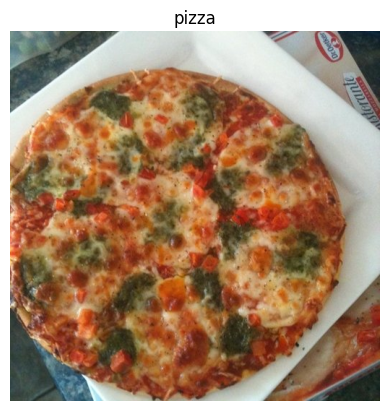

In [9]:
# View a random image of the training dataset
img = view_random_image(target_dir= 'pizza_steak/train/', # we need that slash /
                        target_class= 'pizza')

In [10]:
img.shape # returns height, width and colour channels

(512, 512, 3)

## An end to end example

Let's build a convolutional nn to find patterns in our images:
1. Load our images
2. Preprocess the images
3. Bild a CNN to find patterns
4. Compile the CNN
5. Fit the cnn on our training data

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess the data - scale it to have all the values between 0 and 1
train_datagen  =  ImageDataGenerator(rescale = 1./255.)
valid_datagen = ImageDataGenerator(rescale = 1./255.)

# setup paths to our directories
train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

# Import data from directories and tuurn it into !batches!
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size = 32,
                                               target_size = (224, 224), # common shape, keeps a lot of information
                                               class_mode = 'binary',
                                               seed = 42)
valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (224,224),
                                               class_mode = 'binary',
                                               seed = 42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [12]:
# Build a CNN model (tiny VGG model !CNN explainer website!)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 10,
                           kernel_size = 3,
                           activation = 'relu',
                           input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = 2,
                              padding = 'valid'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(2), # is pool size
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the CNN
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = 'accuracy')

# Fit the model
history_1 = model_1.fit(train_data, # we have the labels thanks to the method flow_from_directory
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 21s 152ms/step - loss: 0.5982 - accuracy: 0.7007 - val_loss: 0.5012 - val_accuracy: 0.7640
Epoch 2/5
47/47 [==============================] - 5s 115ms/step - loss: 0.5001 - accuracy: 0.7653 - val_loss: 0.4340 - val_accuracy: 0.7940
Epoch 3/5
47/47 [==============================] - 6s 130ms/step - loss: 0.4497 - accuracy: 0.7960 - val_loss: 0.3597 - val_accuracy: 0.8580
Epoch 4/5
47/47 [==============================] - 5s 113ms/step - loss: 0.4156 - accuracy: 0.8200 - val_loss: 0.4123 - val_accuracy: 0.8060
Epoch 5/5
47/47 [==============================] - 6s 135ms/step - loss: 0.3988 - accuracy: 0.8267 - val_loss: 0.3236 - val_accuracy: 0.8640


**What is a tiny VGG?**
**CNN explainer website** - visit

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

## Using the same model

In [14]:
# set the seed
tf.random.set_seed(42)

# Create
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the CNN
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = 'accuracy')

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 138ms/step - loss: 1.1435 - accuracy: 0.4880 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 5s 111ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 6s 119ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 6s 125ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 5s 107ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


In [15]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Improving the dense model
#set seed
tf.random.set_seed(42)

# Create
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
    tf.keras.layers.Dense(100, activation = 'relu'), # increase no of hidden units
    tf.keras.layers.Dense(100, activation = 'relu'), # and no of layers
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the CNN
model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = 'accuracy')

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 107ms/step - loss: 2.7491 - accuracy: 0.6433 - val_loss: 1.8059 - val_accuracy: 0.5060
Epoch 2/5
47/47 [==============================] - 7s 153ms/step - loss: 1.0717 - accuracy: 0.6647 - val_loss: 0.7771 - val_accuracy: 0.6720
Epoch 3/5
47/47 [==============================] - 6s 125ms/step - loss: 0.6707 - accuracy: 0.6967 - val_loss: 0.6373 - val_accuracy: 0.6880
Epoch 4/5
47/47 [==============================] - 5s 105ms/step - loss: 0.5535 - accuracy: 0.7493 - val_loss: 0.4408 - val_accuracy: 0.7960
Epoch 5/5
47/47 [==============================] - 6s 137ms/step - loss: 0.4735 - accuracy: 0.7760 - val_loss: 0.4476 - val_accuracy: 0.7820


## Breaking down the CNN creation

Into steps
1. Become one with the data (visualize, visualize, visualize)
2.

### 1. Become one with the data

['1126126.jpg']
Image shape: (384, 512, 3)
['2602611.jpg']
Image shape: (512, 512, 3)


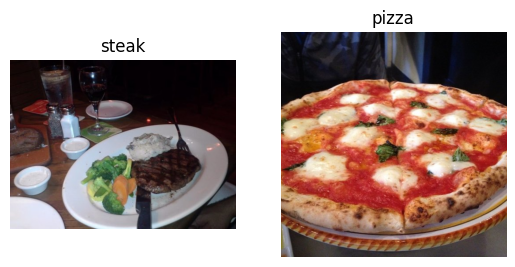

In [18]:
# visualize the data (random samples based on our custom function)
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image('pizza_steak/train/','steak')
plt.subplot(1,2,2)
steak_img = view_random_image('pizza_steak/train/','pizza')

### 2. Preprocess the data (prepare it for the model)

In [19]:
# Define directory dataset paths
train_dir = 'pizza_steak/train/'
test_dir = 'pizza_steak/test/'

Turning our data into **batches**

A batch is a small subset of data. Instead of looking at all images at a time it can look only at e.g. 32 of them